Melanoma:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#library imports
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import PIL
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPool2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

Loading the dataset from google dive

In [3]:
train_dir = "/content/gdrive/MyDrive/melonama/Train"
test_dir = "/content/gdrive/MyDrive/melonama/Test"

counting the images in the dataset

In [4]:

image_count_train = len(list(pathlib.Path(train_dir).glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(pathlib.Path(test_dir).glob('*/*.jpg')))
print(image_count_test)

2239
118


In [5]:
class_names = os.listdir(train_dir)
class_names

['vascular lesion',
 'nevus',
 'melanoma',
 'dermatofibroma',
 'pigmented benign keratosis',
 'basal cell carcinoma',
 'squamous cell carcinoma',
 'actinic keratosis',
 'seborrheic keratosis']

Data processing by setting the hyper parameters

In [6]:

batch_size = 32
img_height = 180
img_width = 180
     

Dataset visualization

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width), label_mode='categorical',
  batch_size=batch_size)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


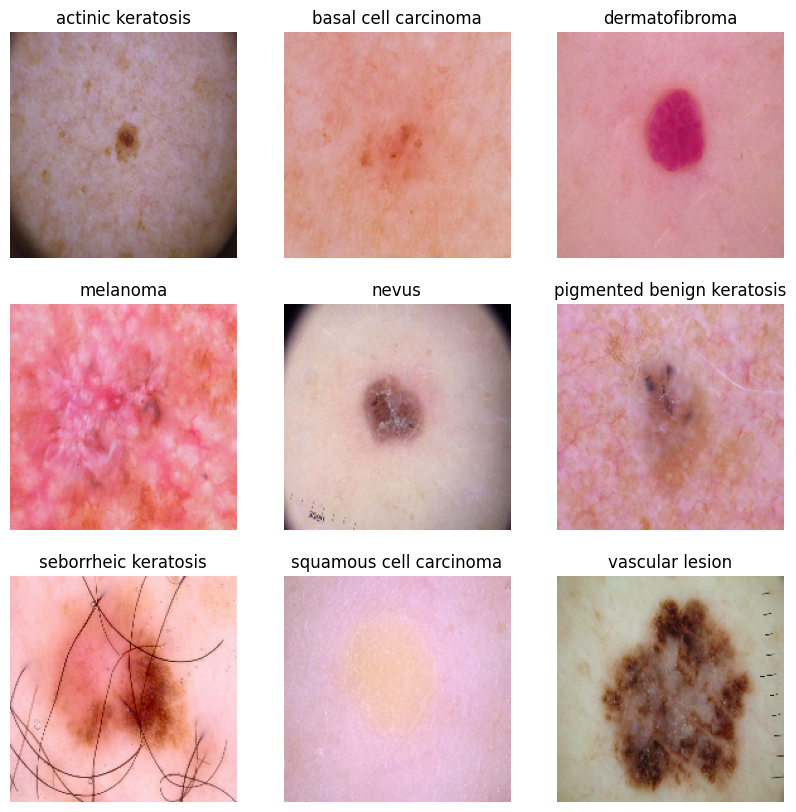

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [13]:
count= []
for path in pathlib.Path(train_dir).iterdir():
    if path.is_dir():

      count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(train_dir)
                if os.path.isdir(os.path.join(train_dir, name))]

#return dataframe with image count and class.
df_train= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No.of Images in train dir'])
df_train

Class_Name  No.of Images in train dir
0             vascular lesion                        139
1                       nevus                        357
2                    melanoma                        438
3              dermatofibroma                         95
4  pigmented benign keratosis                        462
5        basal cell carcinoma                        376
6     squamous cell carcinoma                        181
7           actinic keratosis                        114
8        seborrheic keratosis                         77

In [14]:
count= []
for path in pathlib.Path(test_dir).iterdir():
    if path.is_dir():

      count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(test_dir)
                if os.path.isdir(os.path.join(test_dir, name))]

#return dataframe with image count and class.
df_test= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No. of Images in test dir'])
df_test

Class_Name  No. of Images in test dir
0             vascular lesion                          3
1  pigmented benign keratosis                         16
2                    melanoma                         16
3     squamous cell carcinoma                         16
4        basal cell carcinoma                         16
5           actinic keratosis                         16
6              dermatofibroma                         16
7        seborrheic keratosis                          3
8                       nevus                         16

<Axes: xlabel='No. of Images in test dir', ylabel='Class_Name'>

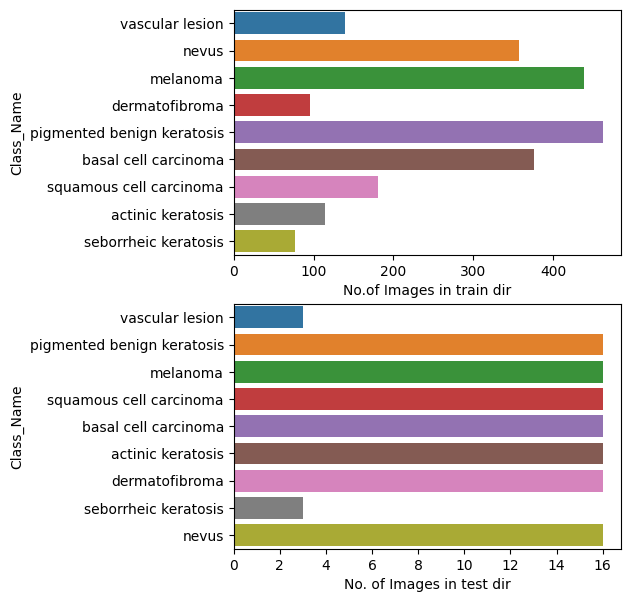

In [15]:

plt.figure(figsize=(5,7))
plt.subplot(2,1,1)
sns.barplot(x="No.of Images in train dir", y="Class_Name", data=df_train,
            label="Class_Name")
plt.subplot(2,1,2)
sns.barplot(x="No. of Images in test dir", y="Class_Name", data=df_test,
            label="Class")

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
input_shape = (180,180,3)
lr = 1e-3
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(7, 7), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(11, 11), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense (9, activation='softmax'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 83, 83, 64)        100416    
                                                                 
 batch_normalization (BatchN  (None, 83, 83, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 41, 64)       0

In [18]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [19]:
epochs = 20
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs,callbacks=[earlystop])

Epoch 1/20
56/56 [==============================] - 407s 2s/step - loss: 19.3154 - accuracy: 0.2846 - val_loss: 28.8999 - val_accuracy: 0.0470
Epoch 2/20
56/56 [==============================] - 3s 60ms/step - loss: 12.1792 - accuracy: 0.3382 - val_loss: 13.4632 - val_accuracy: 0.2260
Epoch 3/20
56/56 [==============================] - 3s 57ms/step - loss: 6.7032 - accuracy: 0.3544 - val_loss: 6.5870 - val_accuracy: 0.2036
Epoch 4/20
56/56 [==============================] - 3s 57ms/step - loss: 4.1401 - accuracy: 0.3231 - val_loss: 2.6691 - val_accuracy: 0.2729
Epoch 5/20
56/56 [==============================] - 3s 60ms/step - loss: 2.4469 - accuracy: 0.4286 - val_loss: 3.4781 - val_accuracy: 0.2215
Epoch 6/20
56/56 [==============================] - 3s 58ms/step - loss: 1.9244 - accuracy: 0.4531 - val_loss: 5.6841 - val_accuracy: 0.2237
Epoch 7/20
56/56 [==============================] - 3s 57ms/step - loss: 1.6819 - accuracy: 0.4782 - val_loss: 2.7689 - val_accuracy: 0.2327
Epoch 8/2

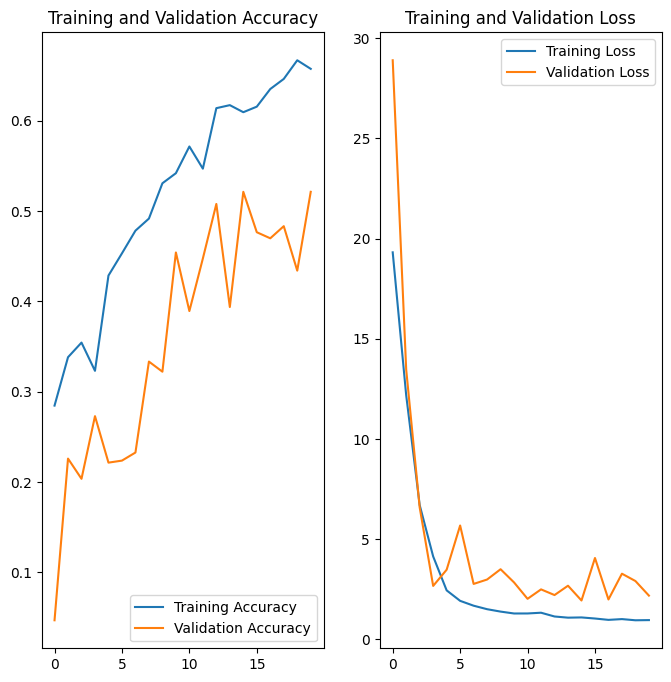

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 20 #edit here
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
#check the model over fitting or under fitting

In [22]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 19ms/step - loss: 2.1860 - accuracy: 0.5213
Accuracy:  0.7399553656578064
Validation Accuracy:  0.5212528109550476
Loss:  0.7405291199684143
Validation Loss 2.186009645462036


model is over fitting, so data is augumented to improve the model performance

In [23]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
        'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis',
         'squamous cell carcinoma','vascular lesion']
train_batches = datagen.flow_from_directory(train_dir, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(test_dir, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


Training the model after data augumentation

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 83, 83, 64)        100416    
                                                                 
 batch_normalization (BatchN  (None, 83, 83, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 41, 64)       0

In [25]:
epochs = 20
# history = model.fit(train_batches,
#   epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)
history = model.fit(train_batches, validation_data=valid_batches, epochs=epochs,callbacks=[earlystop])

Epoch 1/20
35/35 [==============================] - 151s 4s/step - loss: 1.5980 - accuracy: 0.5243 - val_loss: 5.4431 - val_accuracy: 0.2797
Epoch 2/20
35/35 [==============================] - 73s 2s/step - loss: 1.4072 - accuracy: 0.5516 - val_loss: 4.5718 - val_accuracy: 0.3559
Epoch 3/20
35/35 [==============================] - 73s 2s/step - loss: 1.3041 - accuracy: 0.5703 - val_loss: 4.3522 - val_accuracy: 0.2627
Epoch 4/20
35/35 [==============================] - 76s 2s/step - loss: 1.2851 - accuracy: 0.5480 - val_loss: 4.0450 - val_accuracy: 0.3475
Epoch 5/20
35/35 [==============================] - 73s 2s/step - loss: 1.1940 - accuracy: 0.5708 - val_loss: 4.0837 - val_accuracy: 0.3814
Epoch 6/20
35/35 [==============================] - 72s 2s/step - loss: 1.1898 - accuracy: 0.5762 - val_loss: 5.8913 - val_accuracy: 0.2966
Epoch 7/20
35/35 [==============================] - 73s 2s/step - loss: 1.2166 - accuracy: 0.5762 - val_loss: 5.5314 - val_accuracy: 0.3559
Epoch 8/20
35/35 [=

plotting results

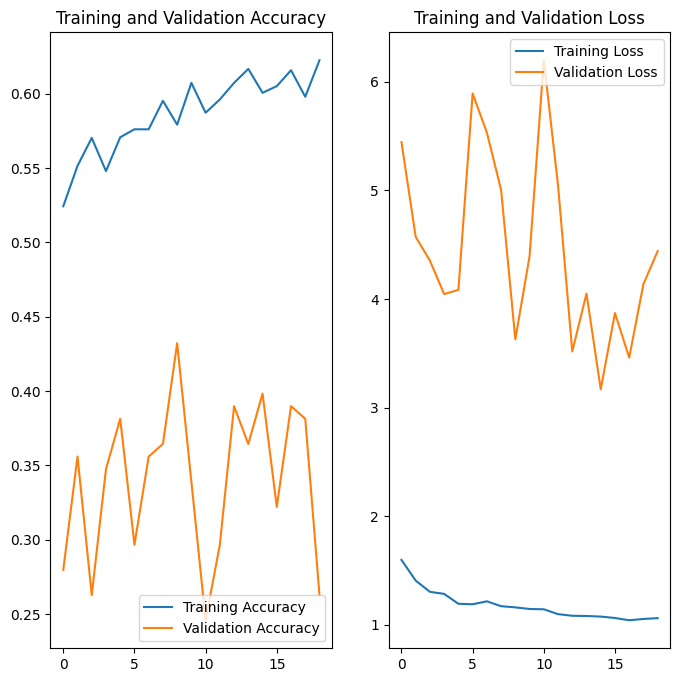

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 19 #edit here
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 18ms/step - loss: 1.2822 - accuracy: 0.5660
Accuracy:  0.5954241156578064
Validation Accuracy:  0.5659955143928528
Loss:  1.1408852338790894
Validation Loss 1.2821881771087646


In [28]:
count= []
for path in pathlib.Path(train_dir).iterdir():
    if path.is_dir():

      count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(train_dir)
                if os.path.isdir(os.path.join(train_dir, name))]

#return dataframe with image count and class.
df_train= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No.of Images in train dir'])
df_train

Class_Name  No.of Images in train dir
0             vascular lesion                        139
1                       nevus                        357
2                    melanoma                        438
3              dermatofibroma                         95
4  pigmented benign keratosis                        462
5        basal cell carcinoma                        376
6     squamous cell carcinoma                        181
7           actinic keratosis                        114
8        seborrheic keratosis                         77

model performance is not improved. So
the imbalanced dataset has to be balanced.
using augumentations, increasing each class count to 500

In [29]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import Augmentor

In [31]:
path_to_training_dataset= train_dir+"/"

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonama/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F35D01B4430>: 100%|██████████| 500/500 [00:27<00:00, 18.35 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonama/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F35D01B4A00>: 100%|██████████| 500/500 [00:26<00:00, 18.53 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonama/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F35D0127BE0>: 100%|██████████| 500/500 [00:29<00:00, 16.78 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonama/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F35D0185250>: 100%|██████████| 500/500 [01:47<00:00,  4.63 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonama/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F35D0194430>: 100%|██████████| 500/500 [01:49<00:00,  4.56 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonama/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F35D00FF2B0>: 100%|██████████| 500/500 [00:21<00:00, 23.08 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonama/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F35D0148280>: 100%|██████████| 500/500 [00:52<00:00,  9.50 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonama/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F35F40DF940>: 100%|██████████| 500/500 [00:21<00:00, 23.00 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonama/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F35D019FA90>: 100%|██████████| 500/500 [00:23<00:00, 20.93 Samples/s]


In [32]:
image_count_train = len(list(pathlib.Path(train_dir).glob('*/output/*.jpg')))
print(image_count_train)

4500


In [33]:
path_list = [x for x in glob.glob(os.path.join(pathlib.Path(train_dir), '*','output', '*.jpg'))]

In [34]:
Balanced_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(train_dir, '*','output', '*.jpg'))]


In [35]:
dataframe_dict_new = dict(zip(path_list, Balanced_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [37]:
new_df['Label'].value_counts()

vascular lesion               500
nevus                         500
melanoma                      500
dermatofibroma                500
pigmented benign keratosis    500
basal cell carcinoma          500
squamous cell carcinoma       500
actinic keratosis             500
seborrheic keratosis          500
Name: Label, dtype: int64

Run from here

In [38]:
data_dir_train="/content/gdrive/MyDrive/melonama/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [40]:
input_shape = (180,180,3)
lr = 1e-4
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense (9, activation='softmax'))

## Number of classes is 9
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 39, 39, 128)      

In [41]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/melonama/model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)

In [42]:
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 2.0781 - accuracy: 0.2309
Epoch 1: val_accuracy improved from -inf to 0.36526, saving model to /content/gdrive/MyDrive/melonama/model.h5
169/169 [==============================] - 44s 228ms/step - loss: 2.0781 - accuracy: 0.2309 - val_loss: 1.7171 - val_accuracy: 0.3653
Epoch 2/30
168/169 [============================>.] - ETA: 0s - loss: 1.6309 - accuracy: 0.3856
Epoch 2: val_accuracy improved from 0.36526 to 0.40238, saving model to /content/gdrive/MyDrive/melonama/model.h5
169/169 [==============================] - 42s 236ms/step - loss: 1.6317 - accuracy: 0.3854 - val_loss: 1.5095 - val_accuracy: 0.4024
Epoch 3/30
168/169 [============================>.] - ETA: 0s - loss: 1.4456 - accuracy: 0.4541
Epoch 3: val_accuracy improved from 0.40238 to 0.44766, saving model to /content/gdrive/MyDrive/melonama/model.h5
169/169 [==============================] - 41s 237ms/step - loss: 1.4455 - accuracy: 0.4542 - val_loss: 1

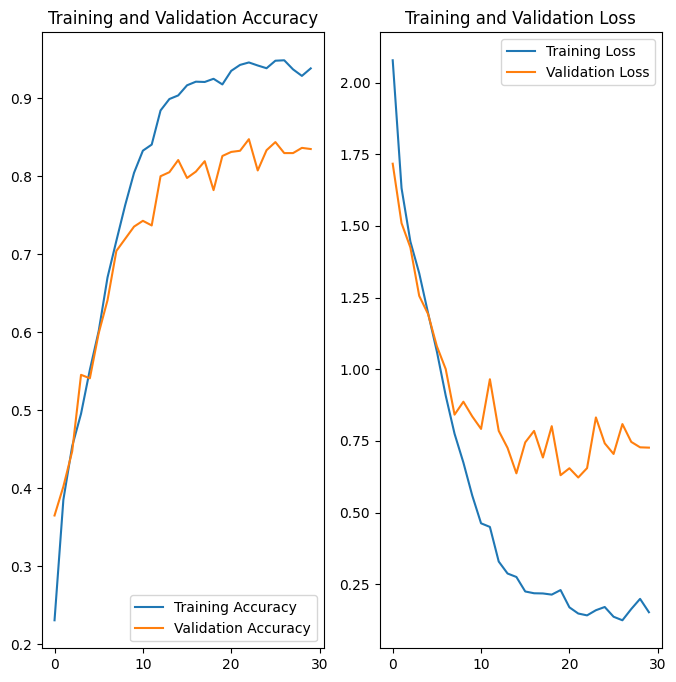

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 30 #edit here
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After balancing the data, From training accuracy and validation accuracy we can conclude that the model is stable, futher increasing the number of epochs will improve the accuracy

In [44]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 6s 115ms/step - loss: 0.7264 - accuracy: 0.8352
Accuracy:  0.9634643793106079
Validation Accuracy:  0.8351892828941345
Loss:  0.09397542476654053
Validation Loss 0.7263749241828918


Predictions on images

1/1 [==============================] - 0s 360ms/step
Actual Class pigmented benign keratosis
Predictive Class pigmented benign keratosis


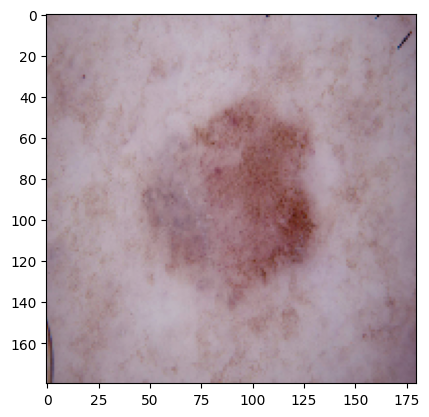

In [45]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
class_num=5
Test_image_path = os.path.join(pathlib.Path(test_dir), class_names[class_num], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)

pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[class_num] +'\n'+ "Predictive Class "+pred_class )

In [46]:
test_dir= "/content/gdrive/MyDrive/melonama/Test"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


1/1 [==============================] - 0s 22ms/step
Actual Class actinic keratosis
Predictive Class squamous cell carcinoma
1/1 [==============================] - 0s 19ms/step
Actual Class basal cell carcinoma
Predictive Class vascular lesion
1/1 [==============================] - 0s 19ms/step
Actual Class dermatofibroma
Predictive Class nevus
1/1 [==============================] - 0s 19ms/step
Actual Class melanoma
Predictive Class pigmented benign keratosis
1/1 [==============================] - 0s 22ms/step
Actual Class nevus
Predictive Class pigmented benign keratosis
1/1 [==============================] - 0s 23ms/step
Actual Class pigmented benign keratosis
Predictive Class pigmented benign keratosis
1/1 [==============================] - 0s 20ms/step
Actual Class seborrheic keratosis
Predictive Class melanoma
1/1 [==============================] - 0s 33ms/step
Actual Class squamous cell carcinoma
Predictive Class squamous cell carcinoma
1/1 [==============================] - 0s 2

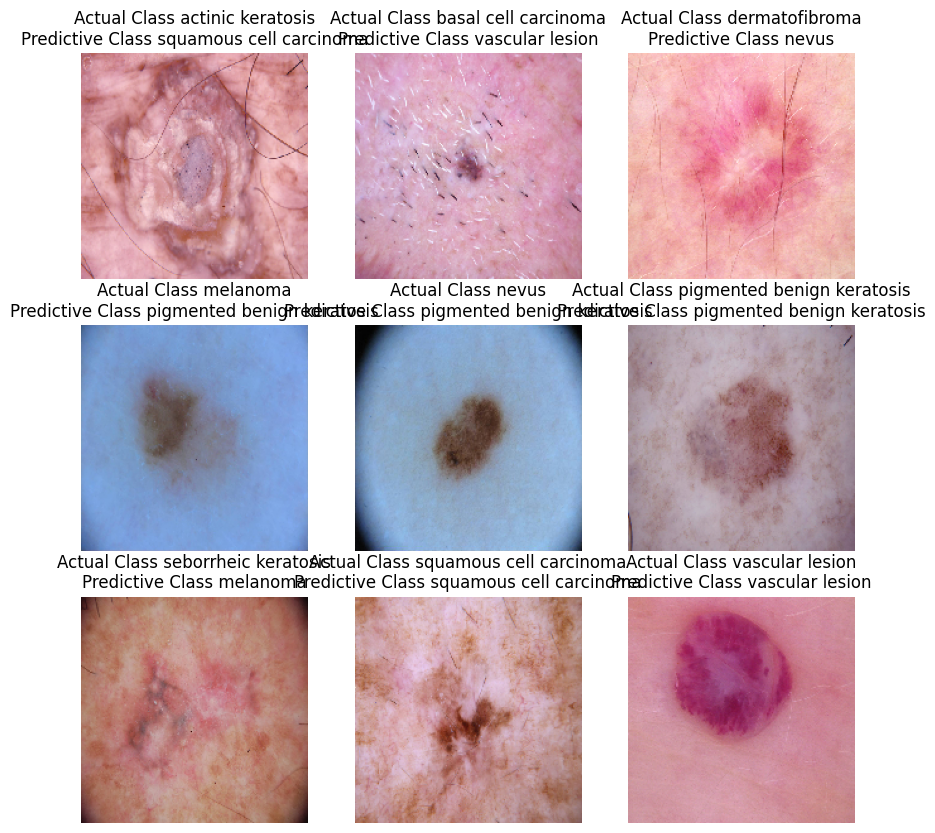

In [47]:
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
test_dir= "/content/gdrive/MyDrive/melonama/Test"

plt.figure(figsize=(10, 10))
for i in range(0,9):
  for images, labels in test_ds.take(1):
      
      Test_image_path = os.path.join(pathlib.Path(test_dir), class_names[i], '*')
      Test_image = glob(Test_image_path)
      Test_image = load_img(Test_image[-1],target_size=(180,180,3))
      # plt.imshow(Test_image)
      # plt.grid(False)

      img = np.expand_dims(Test_image,axis=0)

      pred = model.predict(img)
      pred = np.argmax(pred)
      pred_class = class_names[pred]
      print("Actual Class "+ class_names[i] +'\n'+ "Predictive Class "+pred_class )

      res_text = "Actual Class "+ class_names[i] +'\n'+ "Predictive Class "+pred_class 
      
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(Test_image)
      #plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(res_text)
      plt.axis("off")
    

1/1 [==============================] - 0s 18ms/step
Actual Class vascular lesion
Predictive Class vascular lesion
1/1 [==============================] - 0s 21ms/step
Actual Class actinic keratosis
Predictive Class squamous cell carcinoma
1/1 [==============================] - 0s 20ms/step
Actual Class basal cell carcinoma
Predictive Class vascular lesion
1/1 [==============================] - 0s 18ms/step
Actual Class dermatofibroma
Predictive Class nevus
1/1 [==============================] - 0s 21ms/step
Actual Class melanoma
Predictive Class pigmented benign keratosis
1/1 [==============================] - 0s 19ms/step
Actual Class nevus
Predictive Class pigmented benign keratosis
1/1 [==============================] - 0s 19ms/step
Actual Class pigmented benign keratosis
Predictive Class pigmented benign keratosis
1/1 [==============================] - 0s 18ms/step
Actual Class seborrheic keratosis
Predictive Class melanoma
1/1 [==============================] - 0s 18ms/step
Actual 

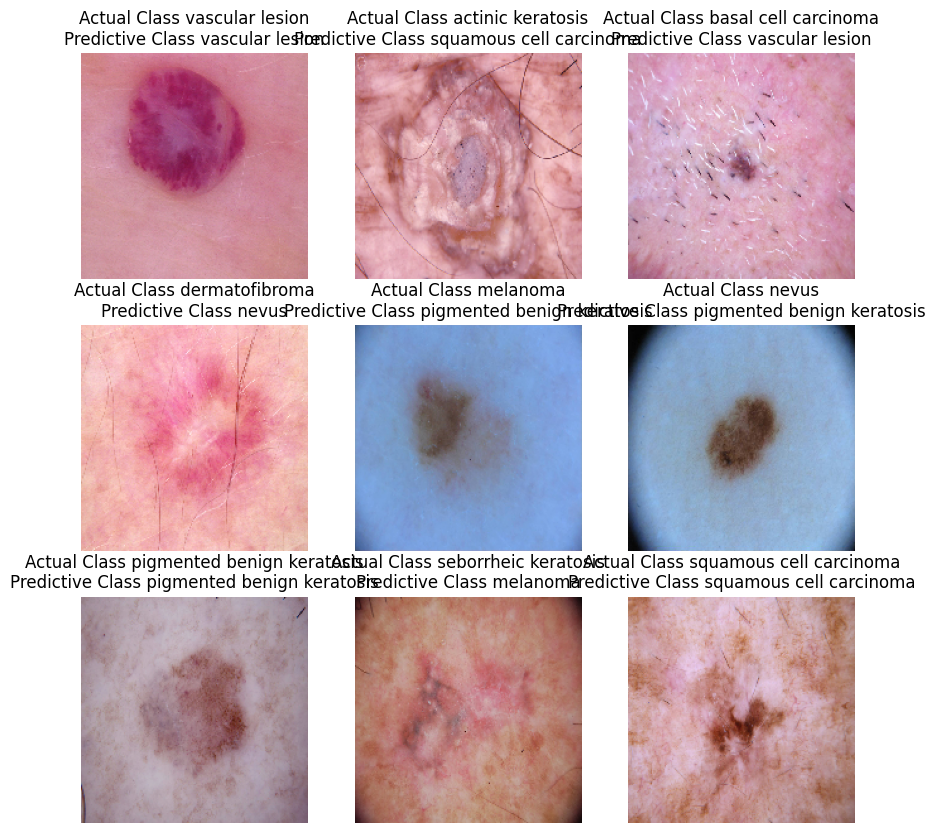

In [48]:
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
test_dir= "/content/gdrive/MyDrive/melonama/Test"

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    Test_image_path = os.path.join(pathlib.Path(test_dir), class_names[i-1], '*')
    Test_image = glob(Test_image_path)
    Test_image = load_img(Test_image[-1],target_size=(180,180,3))
    # plt.imshow(Test_image)
    # plt.grid(False)

    img = np.expand_dims(Test_image,axis=0)

    pred = model.predict(img)
    pred = np.argmax(pred)
    pred_class = class_names[pred]
    print("Actual Class "+ class_names[i-1] +'\n'+ "Predictive Class "+pred_class )

    res_text = "Actual Class "+ class_names[i-1] +'\n'+ "Predictive Class "+pred_class 

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(Test_image)
    #plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(res_text)
    plt.axis("off")

In [49]:
# optional

In [50]:
model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())

#Dense Layer
model.add(Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

In [51]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/melonama/model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)

In [52]:
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 2.2002 - accuracy: 0.1406
Epoch 1: val_accuracy improved from -inf to 0.30215, saving model to /content/gdrive/MyDrive/melonama/model.h5
169/169 [==============================] - 45s 237ms/step - loss: 2.2002 - accuracy: 0.1406 - val_loss: 1.8510 - val_accuracy: 0.3022
Epoch 2/30
168/169 [============================>.] - ETA: 0s - loss: 1.6739 - accuracy: 0.3566
Epoch 2: val_accuracy improved from 0.30215 to 0.41351, saving model to /content/gdrive/MyDrive/melonama/model.h5
169/169 [==============================] - 37s 213ms/step - loss: 1.6736 - accuracy: 0.3563 - val_loss: 1.5755 - val_accuracy: 0.4135
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.4755 - accuracy: 0.4323
Epoch 3: val_accuracy improved from 0.41351 to 0.50483, saving model to /content/gdrive/MyDrive/melonama/model.h5
169/169 [==============================] - 38s 217ms/step - loss: 1.4755 - accuracy: 0.4323 - val_loss: 1

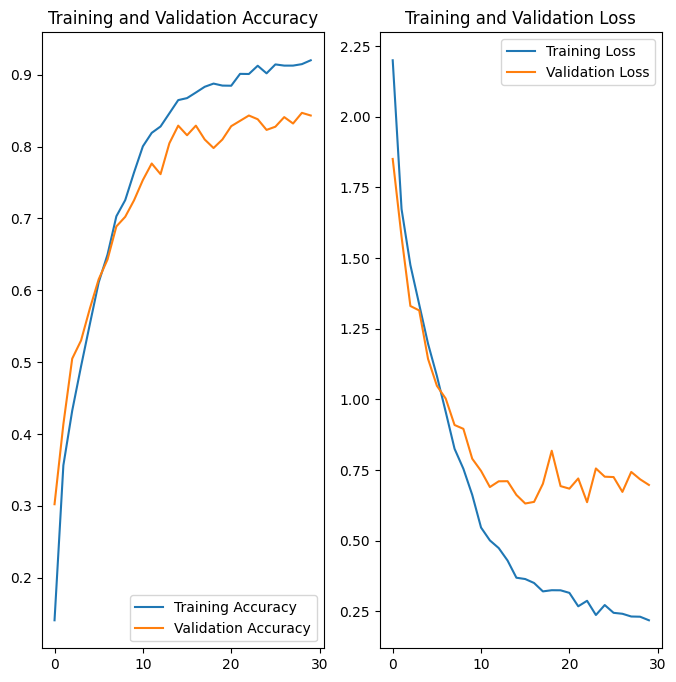

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 30 #edit here
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 8s 153ms/step - loss: 0.6971 - accuracy: 0.8434
Accuracy:  0.9658753871917725
Validation Accuracy:  0.8433555960655212
Loss:  0.08689510077238083
Validation Loss 0.6971487998962402


1/1 [==============================] - 0s 129ms/step
Actual Class basal cell carcinoma
Predictive Class pigmented benign keratosis


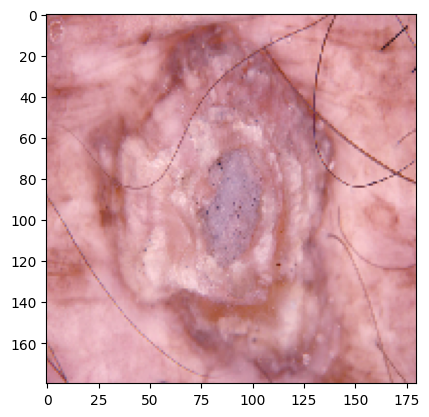

In [55]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img

Test_image_path = os.path.join(pathlib.Path(test_dir), class_names[0], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)

pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )